#Limpieza y transformación de Datasets unificados 
Se realizará el proceso de limpieza para los Datasets antes de implementar los modelos de aprendizaje supervisado, también se  realizará la construcción de algunas nuevas variables y se transformaran los Datasets.

# Setting Preliminares

Importar las librerías básicas 

In [ ]:
# carga de datos
import pandas as pd
import io
from google.colab import files

# manipulación y visualización
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools
import seaborn as sns

import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure
from numpy import corrcoef, transpose, arange
from pylab import pcolor, show, colorbar, xticks, yticks

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)
pd.options.mode.chained_assignment = None

# fechas
import datetime
import time



# Carga de Datos

Función de Google Colab para cargar datos.

In [ ]:
def upload_files ():
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))
    return df

In [ ]:
#cargar
#latinoamerica_resultados.csv
#europa_resultados.csv
#europa_femenina_resultados.csv
df = upload_files() 
df.head()

Saving europa_femenina_resultados.csv to europa_femenina_resultados.csv
User uploaded file "europa_femenina_resultados.csv" with length 1654914 bytes


,fecha,jornada,local,visitante,goles_local,goles_visitante,liga,entrenador_local,pais_entrenador_local,entrenador_visitante,pais_entrenador_visitante
0,27-05-2023,22,Bayern Múnich,Turbine Potsdam,NaN,NaN,bundesliga_femenina,Alexander Straus,Noruega,Sven Weigang,Alemania
1,27-05-2023,22,Werder Bremen,Bayer Leverkusen,NaN,NaN,bundesliga_femenina,Thomas Horsch,Alemania,Robert de Pauw,Países Bajos
2,27-05-2023,22,MSV Duisburg,Hoffenheim,NaN,NaN,bundesliga_femenina,Nico Schneck,Alemania,Gabor Gallai,Alemania
3,27-05-2023,22,Colonia,SGS Essen,NaN,NaN,bundesliga_femenina,Sascha Glass,Alemania,Markus Högner,Alemania
4,27-05-2023,22,Wolfsburgo,SC Freiburg,NaN,NaN,bundesliga_femenina,Tommy Stroot,Alemania,Theresa Merk,Alemania


Invertir index del "df" (si se ejecuta dos veces regresa a la normalidad)

In [ ]:
#df['index'] = list(range(len(df)-1,-1,-1))
#df.set_index('index', inplace = True)
#df = df.sort_index()
#df

In [ ]:
df.shape

(15490, 11)

Comprobamos los tipos y la cantidad de instacias de los datasets

In [ ]:
print(df.shape)
print(df.dtypes)

(15490, 11)
fecha                         object
jornada                        int64
local                         object
visitante                     object
goles_local                  float64
goles_visitante              float64
liga                          object
entrenador_local              object
pais_entrenador_local         object
entrenador_visitante          object
pais_entrenador_visitante     object
dtype: object


Variables numericas

In [ ]:
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)

['jornada' 'goles_local' 'goles_visitante']


Varaibles no numericas

In [ ]:
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print(non_numeric_cols)

['fecha' 'local' 'visitante' 'liga' 'entrenador_local'
 'pais_entrenador_local' 'entrenador_visitante'
 'pais_entrenador_visitante']


#Inicio de proceso de limpieza y transformación 

Mapa de calor para visualizar datos perdidos en el dataset

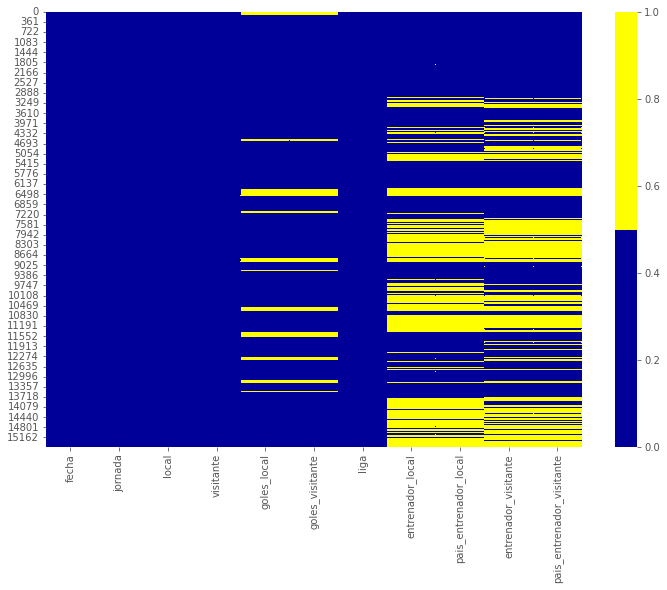

In [ ]:
cols = df.columns[:20] # primeras columnas
colours = ['#000099', '#ffff00'] # amarillo para los perdidos y azul para los no perdidos
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

Número de datos perdidos por columna.

In [ ]:
df.isnull().sum()

fecha                           0
jornada                         0
local                           0
visitante                       0
goles_local                  1233
goles_visitante              1233
liga                            0
entrenador_local             5399
pais_entrenador_local        5399
entrenador_visitante         5469
pais_entrenador_visitante    5469
dtype: int64

indica si la columna tiene algun dato perdido.

In [ ]:
pd.isnull(df).any()

fecha                        False
jornada                      False
local                        False
visitante                    False
goles_local                   True
goles_visitante               True
liga                         False
entrenador_local              True
pais_entrenador_local         True
entrenador_visitante          True
pais_entrenador_visitante     True
dtype: bool

Porcentaje de datos perdidos

In [ ]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

fecha - 0%
jornada - 0%
local - 0%
visitante - 0%
goles_local - 8%
goles_visitante - 8%
liga - 0%
entrenador_local - 35%
pais_entrenador_local - 35%
entrenador_visitante - 35%
pais_entrenador_visitante - 35%


Obtener los valores unicos de la columna "local"

In [ ]:
equipos_unicos=pd.unique(df['local'])

In [ ]:
# funcion para detectar NaN o nan
def isNaN(num):
    return num != num

In [ ]:
isNaN(math.nan)

True

Realizar copia de dataframe

In [ ]:
df_copy=df.copy()

Completar la columna de los entrenadores con el entrenador anterior

In [ ]:
#Completar entrenadores locales
for equipo in equipos_unicos:
  entrenador_reemplazo = math.nan
  pais_entrenador_reemplazo = math.nan
  for filas in list(range(len(df)-1,-1,-1)):
    if equipo == df['local'][filas]:
      if isNaN(df['entrenador_local'][filas]):
        df_copy['entrenador_local'][filas] = entrenador_reemplazo
        df_copy['pais_entrenador_local'][filas] = pais_entrenador_reemplazo

      else:
        entrenador_reemplazo = df['entrenador_local'][filas]
        pais_entrenador_reemplazo = df['pais_entrenador_local'][filas]
      


In [ ]:
#Completar entrenadores visitantes
for equipo in equipos_unicos:
  entrenador_reemplazo = math.nan
  pais_entrenador_reemplazo = math.nan
  for filas in list(range(len(df)-1,-1,-1)):
    if equipo == df['visitante'][filas]:
      if isNaN(df['entrenador_visitante'][filas]):
        df_copy['entrenador_visitante'][filas] = entrenador_reemplazo
        df_copy['pais_entrenador_visitante'][filas] = pais_entrenador_reemplazo

      else:
        entrenador_reemplazo = df['entrenador_visitante'][filas]
        pais_entrenador_reemplazo = df['pais_entrenador_visitante'][filas]
      


Mapa de calor para visualizar datos perdidos 

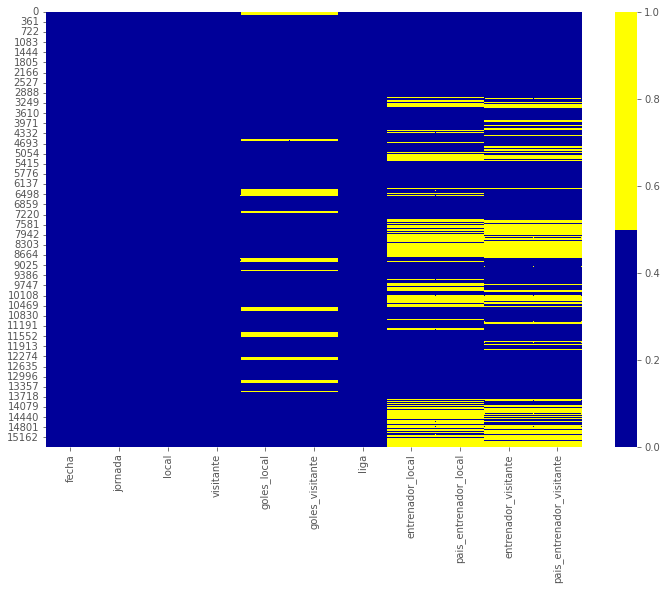

In [ ]:
cols = df_copy.columns[:20] # primeras columnas
colours = ['#000099', '#ffff00'] # amarillo para los perdidos y azul para los no perdidos
sns.heatmap(df_copy[cols].isnull(), cmap=sns.color_palette(colours))

Porcentaje de datos perdidos

In [ ]:
for col in df_copy.columns:
    pct_missing = np.mean(df_copy[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

fecha - 0%
jornada - 0%
local - 0%
visitante - 0%
goles_local - 8%
goles_visitante - 8%
liga - 0%
entrenador_local - 24%
pais_entrenador_local - 24%
entrenador_visitante - 25%
pais_entrenador_visitante - 25%


Eliminar filas con valores perdidos, como solo hay datos "NaN" en las columnas de los goles, se puede utilizar la funcion dropna(axis=0) que borra todas las filas donde halla un dato perdido, basandose en la columna "goles_local"

In [ ]:
df_sin_perdidos = df_copy.dropna(subset=["goles_local"])

In [ ]:
df_sin_perdidos.shape

(14257, 11)

Mapa de calor para visualizar datos perdidos

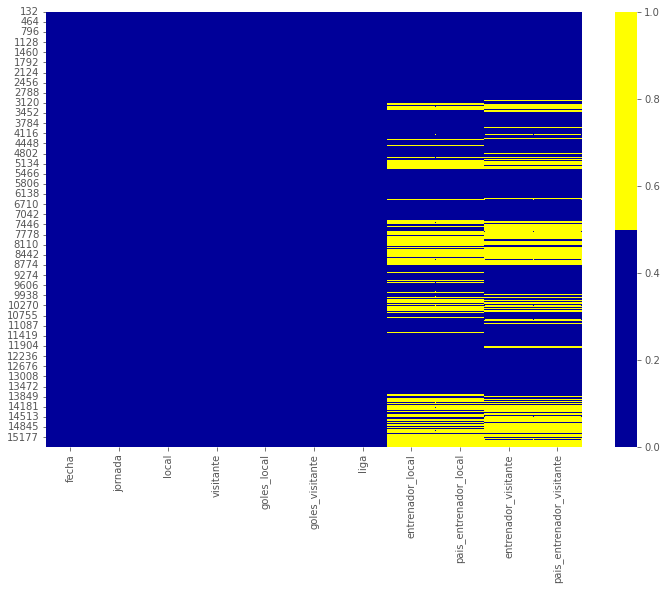

In [ ]:
cols = df_sin_perdidos.columns[:20] # primeras columnas
colours = ['#000099', '#ffff00'] # amarillo para los perdidos y azul para los no perdidos
sns.heatmap(df_sin_perdidos[cols].isnull(), cmap=sns.color_palette(colours))

Número de datos perdidos por columna.

In [ ]:
df_sin_perdidos.isnull().sum()

fecha                           0
jornada                         0
local                           0
visitante                       0
goles_local                     0
goles_visitante                 0
liga                            0
entrenador_local             3682
pais_entrenador_local        3682
entrenador_visitante         3776
pais_entrenador_visitante    3776
dtype: int64

indica si la columna tiene algun dato perdido.

In [ ]:
pd.isnull(df_sin_perdidos).any()

fecha                        False
jornada                      False
local                        False
visitante                    False
goles_local                  False
goles_visitante              False
liga                         False
entrenador_local              True
pais_entrenador_local         True
entrenador_visitante          True
pais_entrenador_visitante     True
dtype: bool

Reiniciar index del dataframe

In [ ]:
df_sin_perdidos.reset_index(drop = True, inplace = True)

Para los valores perdidos de las columnas “entrenador_local”, “pais_entrenador_local”, “entrenador _visitante” y “país_entrenador_visitante”, se reemplazan los valores “NaN” por el String “sin_entrenador” y “sin país ” respectivamente.

In [ ]:
df_sin_perdidos["entrenador_local"] = df_sin_perdidos["entrenador_local"].replace(np.nan, "sin entrenador")
df_sin_perdidos["entrenador_visitante"] = df_sin_perdidos["entrenador_visitante"].replace(np.nan, "sin entrenador")
df_sin_perdidos["pais_entrenador_local"] = df_sin_perdidos["pais_entrenador_local"].replace(np.nan, "sin país")
df_sin_perdidos["pais_entrenador_visitante"] = df_sin_perdidos["pais_entrenador_visitante"].replace(np.nan, "sin país")

Porcentaje de datos perdidos 

In [ ]:
for col in df_sin_perdidos.columns:
    pct_missing = np.mean(df_sin_perdidos[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

fecha - 0%
jornada - 0%
local - 0%
visitante - 0%
goles_local - 0%
goles_visitante - 0%
liga - 0%
entrenador_local - 0%
pais_entrenador_local - 0%
entrenador_visitante - 0%
pais_entrenador_visitante - 0%


Guardar los valores únicos de los equipos en la variable “equipos_unicos_df”

In [ ]:
equipos_unicos_df = pd.unique(df_sin_perdidos['local'])
#equipos_unicos_europa

Crear columnas de indicador de victorias derrotas y empates

In [ ]:
resultado_local=[]
resultado_visitante=[]

for partido in list(range(len(df_sin_perdidos))):
  if df_sin_perdidos['goles_local'][partido] > df_sin_perdidos['goles_visitante'][partido]:
    resultado_local.append('Victoria')
    resultado_visitante.append('Derrota')
  elif df_sin_perdidos['goles_local'][partido] == df_sin_perdidos['goles_visitante'][partido]:
    resultado_local.append('Empate')
    resultado_visitante.append('Empate')
  elif df_sin_perdidos['goles_local'][partido] < df_sin_perdidos['goles_visitante'][partido]:
    resultado_local.append('Derrota')
    resultado_visitante.append('Victoria')

df_sin_perdidos['resultado_local'] = resultado_local
df_sin_perdidos['resultado_visitante'] = resultado_visitante

In [ ]:
df_sin_perdidos

,fecha,jornada,local,visitante,goles_local,goles_visitante,liga,entrenador_local,pais_entrenador_local,entrenador_visitante,pais_entrenador_visitante,resultado_local,resultado_visitante
0,15-05-2022,22,Colonia,SC Freiburg,0.0,0.0,bundesliga_femenina,Sascha Glass,Alemania,Daniel Kraus,Alemania,Empate,Empate
1,15-05-2022,22,Hoffenheim,SC Sand,3.0,3.0,bundesliga_femenina,Gabor Gallai,Alemania,Alexander Fischinger,Alemania,Empate,Empate
2,15-05-2022,22,Eintracht Frankfurt,Werder Bremen,4.0,0.0,bundesliga_femenina,Niko Arnautis,Alemania,Thomas Horsch,Alemania,Victoria,Derrota
3,15-05-2022,22,Bayern Múnich,Turbine Potsdam,5.0,0.0,bundesliga_femenina,Jens Scheuer,Alemania,Sofian Chahed,Túnez,Victoria,Derrota
4,15-05-2022,22,Wolfsburgo,Bayer Leverkusen,7.0,1.0,bundesliga_femenina,Tommy Stroot,Alemania,Achim Feifel,Alemania,Victoria,Derrota
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14252,13-04-2009,1,SK Trondheims-Ørn,Kolbotn IL,1.0,1.0,toppserien_noruega_femenina,sin entrenador,sin país,sin entrenador,sin país,Empate,Empate
14253,13-04-2009,1,Kattem IL,Klepp IL,2.0,1.0,toppserien_noruega_femenina,sin entrenador,sin país,sin entrenador,sin país,Victoria,Derrota
14254,13-04-2009,1,Team Strømmen,Arna-Bjørnar,0.0,0.0,toppserien_noruega_femenina,sin entrenador,sin país,sin entrenador,sin país,Empate,Empate
14255,13-04-2009,1,Amazon Grimstad,IL Sandviken,1.0,0.0,toppserien_noruega_femenina,sin entrenador,sin país,sin entrenador,sin país,Victoria,Derrota


Crear columna de puntos en la temporada de cada equipo

In [ ]:
#añadir nueva columna de puntos vacia 
puntos_actuales_local=[None]*len(df_sin_perdidos)
puntos_actuales_visitante=[None]*len(df_sin_perdidos)
for equipo in equipos_unicos_df:
  puntos = 0
  jornada_anterior = df_sin_perdidos['jornada'][len(df_sin_perdidos)-1]
  for recorrer_partidos in list(range(len(df_sin_perdidos)-1,-1,-1)):
    #validar si la jornada sigue aumentando

    if df_sin_perdidos['jornada'][recorrer_partidos] < jornada_anterior:
      puntos = 0
    jornada_anterior = df_sin_perdidos['jornada'][recorrer_partidos]
    #validar si el equipo de estudio se encuentra en la iteración 
    if df_sin_perdidos['local'][recorrer_partidos] == equipo:
      #validar si el equipo local gano, empato o perdio
      if df_sin_perdidos['resultado_local'][recorrer_partidos] == 'Victoria':
        puntos = puntos + 3
      elif df_sin_perdidos['resultado_local'][recorrer_partidos] == 'Empate':
        puntos = puntos + 1
      elif df_sin_perdidos['resultado_local'][recorrer_partidos]== 'Derrota':
        puntos = puntos

      #agregar puntos a la lista de locales
      puntos_actuales_local[recorrer_partidos] = puntos 


    elif df_sin_perdidos['visitante'][recorrer_partidos] == equipo:
      #validar si el equipo visitante gano, empato o perdio
      if df_sin_perdidos['resultado_visitante'][recorrer_partidos] == 'Victoria':
        puntos = puntos + 3
      elif df_sin_perdidos['resultado_visitante'][recorrer_partidos] == 'Empate':
        puntos = puntos + 1
      elif df_sin_perdidos['resultado_visitante'][recorrer_partidos] == 'Derrota':
        puntos = puntos
      
      #agregar puntos a la lista de visitantes
      puntos_actuales_visitante[recorrer_partidos] = puntos 

df_sin_perdidos['puntos_actuales_local'] = puntos_actuales_local
df_sin_perdidos['puntos_actuales_visitante'] = puntos_actuales_visitante

Creacion de nuevo dataframe con promedio de goles

In [ ]:
# listas para construir dataframe nuevo
jornada = []
fecha = []
puntos_actuales = []
equipo_ = []
liga = []
entrenador_nuevo = []
promedio_goles_hechos_antes_de_cambio_entrenador_1_5 = []
promedio_goles_hechos_despues_de_cambio_entrenador_1_5 = []

promedio_goles_recibidos_antes_de_cambio_entrenador_1_5 = []
promedio_goles_recibidos_despues_de_cambio_entrenador_1_5 = []

puntos_hechos_despues_de_cambio_entrenador_1_5 = []
puntos_hechos_antes_de_cambio_entrenador_1_5 = []

porcentaje_victorias_despues_de_cambio_entrenador_1_5 = []
porcentaje_empates_despues_de_cambio_entrenador_1_5 = []
porcentaje_derrotas_despues_de_cambio_entrenador_1_5 = []

porcentaje_victorias_antes_de_cambio_entrenador_1_5 = []
porcentaje_empates_antes_de_cambio_entrenador_1_5 = []
porcentaje_derrotas_antes_de_cambio_entrenador_1_5 = []

#recorrer equipos e intercambiar valor de columnas
for equipo in equipos_unicos_df:
  partidos_equipo = df_sin_perdidos[(df_sin_perdidos['local'] == equipo) | (df_sin_perdidos['visitante'] == equipo)]
  partidos_equipo.reset_index(drop = True, inplace = True)
  local = None
  visitante = None
  goles_local = None
  goles_visitante = None
  entrenador_local = None
  entrenador_visitante = None
  resultado_local = None
  resultado_visitante = None
  puntos_actuales_local = None
  puntos_actuales_visitante = None

  for recorrer_partidos in list(range(len(partidos_equipo))):
    if partidos_equipo['local'][recorrer_partidos] == equipo:
      continue 
    elif partidos_equipo['visitante'][recorrer_partidos] == equipo:
        local = partidos_equipo['local'][recorrer_partidos]
        visitante = partidos_equipo['visitante'][recorrer_partidos]

        goles_local = partidos_equipo['goles_local'][recorrer_partidos]
        goles_visitante = partidos_equipo['goles_visitante'][recorrer_partidos]

        entrenador_local = partidos_equipo['entrenador_local'][recorrer_partidos]
        entrenador_visitante = partidos_equipo['entrenador_visitante'][recorrer_partidos]

        resultado_local = partidos_equipo['resultado_local'][recorrer_partidos]
        resultado_visitante = partidos_equipo['resultado_visitante'][recorrer_partidos]

        puntos_actuales_local = partidos_equipo['puntos_actuales_local'][recorrer_partidos]
        puntos_actuales_visitante = partidos_equipo['puntos_actuales_visitante'][recorrer_partidos]
#cambio de  posición de columnas
        partidos_equipo['local'][recorrer_partidos] = visitante
        partidos_equipo['visitante'][recorrer_partidos] = local

        partidos_equipo['goles_local'][recorrer_partidos] = goles_visitante
        partidos_equipo['goles_visitante'][recorrer_partidos] = goles_local

        partidos_equipo['entrenador_local'][recorrer_partidos] = entrenador_visitante
        partidos_equipo['entrenador_visitante'][recorrer_partidos] = entrenador_local

        partidos_equipo['resultado_local'][recorrer_partidos] = resultado_visitante
        partidos_equipo['resultado_visitante'][recorrer_partidos] = resultado_local

        partidos_equipo['puntos_actuales_local'][recorrer_partidos] = puntos_actuales_visitante
        partidos_equipo['puntos_actuales_visitante'][recorrer_partidos] = puntos_actuales_local

  #variable para comparar cuando el entrenador ha cambiado
  detector_cambio_entrenador = partidos_equipo['entrenador_local'][len(partidos_equipo)-1]
  #recorrer partidos 
  for recorrer_partidos in list(range(len(partidos_equipo)-1,-1,-1)):

    if detector_cambio_entrenador != partidos_equipo['entrenador_local'][recorrer_partidos]:
      #actualizar detector
      detector_cambio_entrenador = partidos_equipo['entrenador_local'][recorrer_partidos]
      #jornada
      jornada.append(partidos_equipo['jornada'][recorrer_partidos])
      #fecha
      fecha.append(partidos_equipo['fecha'][recorrer_partidos])
      #puntos actuales
      puntos_actuales.append(partidos_equipo['puntos_actuales_local'][recorrer_partidos])
      #equipo
      equipo_.append(equipo)
      #liga
      liga.append(partidos_equipo['liga'][recorrer_partidos])
      #entrenador_nuevo
      entrenador_nuevo.append(partidos_equipo['entrenador_local'][recorrer_partidos])
      ############################promedio de goles hechos despues y antes de cambio de entrenador###############
      promedio_goles=[]#acumulador de goles para promedio
      for x in list(range(0,-15,-1)):
        entrenador_iterado = None
        try:
          entrenador_iterado = partidos_equipo['entrenador_local'][recorrer_partidos + x]
        except:
          break
        if detector_cambio_entrenador != entrenador_iterado:
          break
        promedio_goles.append(partidos_equipo['goles_local'][recorrer_partidos + x])

      
      #promedio de goles hechos despues del cambio del entrenador 1 a 5 partidos
      promedio_goles_hechos_despues_de_cambio_entrenador_1_5.append((np.sum(promedio_goles[0:5]))/len(promedio_goles[0:5]))


      promedio_goles=[]#acumulador de goles para promedio
      for x in list(range(1,16)):
        entrenador_iterado = None
        try:
          entrenador_iterado = partidos_equipo['entrenador_local'][recorrer_partidos + x]
        except:
          break

        promedio_goles.append(partidos_equipo['goles_local'][recorrer_partidos + x])  

      #promedio de goles hechos antes del cambio del entrenador 1 a 5 partidos
      promedio_goles_hechos_antes_de_cambio_entrenador_1_5.append((np.sum(promedio_goles[0:5]))/len(promedio_goles[0:5]))


      ##############################promedio de goles recibidos antes de cambio de entrenador#################################
      promedio_goles=[]#acumulador de goles para promedio
      for x in list(range(0,-15,-1)):
        entrenador_iterado = None
        try:
          entrenador_iterado = partidos_equipo['entrenador_local'][recorrer_partidos + x]
        except:
          break
        if detector_cambio_entrenador != entrenador_iterado:
          break
        promedio_goles.append(partidos_equipo['goles_visitante'][recorrer_partidos + x])


      #promedio de goles recibidos despues del cambio del entrenador 1 a 5 partidos
      promedio_goles_recibidos_despues_de_cambio_entrenador_1_5.append((np.sum(promedio_goles[0:5]))/len(promedio_goles[0:5]))



      promedio_goles=[]#acumulador de goles para promedio
      for x in list(range(1,16)):
        entrenador_iterado = None
        try:
          entrenador_iterado = partidos_equipo['entrenador_local'][recorrer_partidos + x]
        except:
          break

        promedio_goles.append(partidos_equipo['goles_visitante'][recorrer_partidos + x])  

      #promedio de goles recibidos antes del cambio del entrenador 1 a 5 partidos
      promedio_goles_recibidos_antes_de_cambio_entrenador_1_5.append((np.sum(promedio_goles[0:5]))/len(promedio_goles[0:5]))

      ############################promedio de puntos hechos despues y antes de cambio de entrenador###############
      puntos_hechos=[]#acumulador de goles para promedio
      for x in list(range(0,-15,-1)):
        entrenador_iterado = None
        try:
          entrenador_iterado = partidos_equipo['entrenador_local'][recorrer_partidos + x]
        except:
          break
        if detector_cambio_entrenador != entrenador_iterado:
          break
        
        if partidos_equipo['resultado_local'][recorrer_partidos + x] == 'Victoria':
          puntos_hechos.append(3)
        elif partidos_equipo['resultado_local'][recorrer_partidos + x] == 'Empate':
          puntos_hechos.append(1)
        elif partidos_equipo['resultado_local'][recorrer_partidos + x] == 'Derrota':
          puntos_hechos.append(0)

#        puntos_hechos.append(partidos_equipo['resultado_local'][recorrer_partidos + x])

      
      #promedio de goles hechos despues del cambio del entrenador 1 a 5 partidos
      puntos_hechos_despues_de_cambio_entrenador_1_5.append((np.sum(puntos_hechos[0:5])))


      puntos_hechos=[]#acumulador de goles para promedio
      for x in list(range(1,16)):
        entrenador_iterado = None
        try:
          entrenador_iterado = partidos_equipo['entrenador_local'][recorrer_partidos + x]
        except:
          break

        if partidos_equipo['resultado_local'][recorrer_partidos + x] == 'Victoria':
          puntos_hechos.append(3)
        elif partidos_equipo['resultado_local'][recorrer_partidos + x] == 'Empate':
          puntos_hechos.append(1)
        elif partidos_equipo['resultado_local'][recorrer_partidos + x] == 'Derrota':
          puntos_hechos.append(0)

#        puntos_hechos.append(partidos_equipo['resultado_local'][recorrer_partidos + x])

      
      #promedio de goles hechos despues del cambio del entrenador 1 a 5 partidos
      puntos_hechos_antes_de_cambio_entrenador_1_5.append((np.sum(puntos_hechos[0:5])))



      ################################################################################################################

      #crear lista para acumular resultados despues de cambio de entrenador
      lista_resultados=[]#acumulador de victorias
      for x in list(range(0,-15,-1)):
        entrenador_iterado = None
        try:
          entrenador_iterado = partidos_equipo['entrenador_local'][recorrer_partidos + x]
        except:
          break
        if detector_cambio_entrenador != entrenador_iterado:
          break
        lista_resultados.append(partidos_equipo['resultado_local'][recorrer_partidos + x])
      #print(lista_resultados)
      #contar lista y obtener promedio 1 a 5 partidos
      contador_victorias_1_5=0
      contador_empates_1_5=0
      contador_derrotas_1_5=0

      for y in lista_resultados[0:5]:
        if y == "Victoria":
          contador_victorias_1_5 += 1
      #print(contador_victorias_1_5)
      #porcentaje de empates  despues del cambio del entrenador 1 a 5 partidos
      porcentaje_victorias_despues_de_cambio_entrenador_1_5.append(contador_victorias_1_5/len(lista_resultados[0:5]))
      #print(contador_victorias_1_5/len(lista_resultados[0:5]))

      for y in lista_resultados[0:5]:
        if y == "Empate":
          contador_empates_1_5 += 1
      #print(contador_empates_1_5)
      #porcentaje de victorias  despues del cambio del entrenador 1 a 5 partidos
      porcentaje_empates_despues_de_cambio_entrenador_1_5.append(contador_empates_1_5/len(lista_resultados[0:5]))
      #print(contador_empates_1_5/len(lista_resultados[0:5]))
  
      for y in lista_resultados[0:5]:
        if y == "Derrota":
          contador_derrotas_1_5 += 1
      #print(contador_derrotas_1_5)
      #porcentaje de derrotas  despues del cambio del entrenador 1 a 5 partidos
      porcentaje_derrotas_despues_de_cambio_entrenador_1_5.append(contador_derrotas_1_5/len(lista_resultados[0:5]))
      #print(contador_derrotas_1_5/len(lista_resultados[0:5]))

 
##3
      #crear lista para acumular resultados antes de cambio de entrenador
      lista_resultados=[]#acumulador de victorias
      for x in list(range(1,16)):
        entrenador_iterado = None
        try:
          entrenador_iterado = partidos_equipo['entrenador_local'][recorrer_partidos + x]
        except:
          break

        lista_resultados.append(partidos_equipo['resultado_local'][recorrer_partidos + x])  

      #contar lista y obtener promedio 1 a 5 partidos
      contador_victorias_1_5=0
      contador_empates_1_5=0
      contador_derrotas_1_5=0

      for y in lista_resultados[0:5]:
        if y == "Victoria":
          contador_victorias_1_5 += 1
      #print(contador_victorias_1_5)
      #porcentaje de empates  antes del cambio del entrenador 1 a 5 partidos
      porcentaje_victorias_antes_de_cambio_entrenador_1_5.append(contador_victorias_1_5/len(lista_resultados[0:5]))
      #print(contador_victorias_1_5/len(lista_resultados[0:5]))

      for y in lista_resultados[0:5]:
        if y == "Empate":
          contador_empates_1_5 += 1
      #print(contador_empates_1_5)
      #porcentaje de victorias  antes del cambio del entrenador 1 a 5 partidos
      porcentaje_empates_antes_de_cambio_entrenador_1_5.append(contador_empates_1_5/len(lista_resultados[0:5]))
      #print(contador_empates_1_5/len(lista_resultados[0:5]))
  
      for y in lista_resultados[0:5]:
        if y == "Derrota":
          contador_derrotas_1_5 += 1
      #print(contador_derrotas_1_5)
      #porcentaje de derrotas  antes del cambio del entrenador 1 a 5 partidos
      porcentaje_derrotas_antes_de_cambio_entrenador_1_5.append(contador_derrotas_1_5/len(lista_resultados[0:5]))
      #print(contador_derrotas_1_5/len(lista_resultados[0:5]))
 
 

df_promedio_goles = pd.DataFrame({'jornada':jornada,'fecha':fecha,'puntos_actuales':puntos_actuales,'equipo':equipo_,'liga':liga,'entrenador_nuevo':entrenador_nuevo,
                                  'promedio_goles_hechos_antes_de_cambio_entrenador_1_5':promedio_goles_hechos_antes_de_cambio_entrenador_1_5,
                                  'promedio_goles_hechos_despues_de_cambio_entrenador_1_5':promedio_goles_hechos_despues_de_cambio_entrenador_1_5,
                                  'promedio_goles_recibidos_antes_de_cambio_entrenador_1_5':promedio_goles_recibidos_antes_de_cambio_entrenador_1_5,
                                  'promedio_goles_recibidos_despues_de_cambio_entrenador_1_5':promedio_goles_recibidos_despues_de_cambio_entrenador_1_5,
                                  'puntos_hechos_antes_de_cambio_entrenador_1_5':puntos_hechos_antes_de_cambio_entrenador_1_5,
                                  'puntos_hechos_despues_de_cambio_entrenador_1_5':puntos_hechos_despues_de_cambio_entrenador_1_5,
                                  'porcentaje_victorias_despues_de_cambio_entrenador_1_5':porcentaje_victorias_despues_de_cambio_entrenador_1_5,
                                  'porcentaje_victorias_antes_de_cambio_entrenador_1_5':porcentaje_victorias_antes_de_cambio_entrenador_1_5,
                                  'porcentaje_empates_despues_de_cambio_entrenador_1_5':porcentaje_empates_despues_de_cambio_entrenador_1_5,
                                  'porcentaje_empates_antes_de_cambio_entrenador_1_5':porcentaje_empates_antes_de_cambio_entrenador_1_5,
                                  'porcentaje_derrotas_despues_de_cambio_entrenador_1_5':porcentaje_derrotas_despues_de_cambio_entrenador_1_5,
                                  'porcentaje_derrotas_antes_de_cambio_entrenador_1_5':porcentaje_derrotas_antes_de_cambio_entrenador_1_5,})


In [ ]:
df_promedio_goles

,jornada,fecha,puntos_actuales,equipo,liga,entrenador_nuevo,promedio_goles_hechos_antes_de_cambio_entrenador_1_5,promedio_goles_hechos_despues_de_cambio_entrenador_1_5,promedio_goles_recibidos_antes_de_cambio_entrenador_1_5,promedio_goles_recibidos_despues_de_cambio_entrenador_1_5,puntos_hechos_antes_de_cambio_entrenador_1_5,puntos_hechos_despues_de_cambio_entrenador_1_5,porcentaje_victorias_despues_de_cambio_entrenador_1_5,porcentaje_victorias_antes_de_cambio_entrenador_1_5,porcentaje_empates_despues_de_cambio_entrenador_1_5,porcentaje_empates_antes_de_cambio_entrenador_1_5,porcentaje_derrotas_despues_de_cambio_entrenador_1_5,porcentaje_derrotas_antes_de_cambio_entrenador_1_5
0,8,15-11-2015,2,Colonia,bundesliga_femenina,Nico Reese,1.0,0.5,2.8,2.5,1,1,0.0,0.0,0.5,0.2,0.5,0.8
1,10,06-12-2015,5,Colonia,bundesliga_femenina,Marcus Kühn,1.0,0.8,2.2,1.4,2,4,0.2,0.0,0.2,0.4,0.6,0.6
2,1,03-09-2017,0,Colonia,bundesliga_femenina,Willi Breuer,1.4,0.4,3.0,3.8,6,0,0.0,0.4,0.0,0.0,1.0,0.6
3,12,04-06-2020,8,Colonia,bundesliga_femenina,Sascha Glass,2.0,1.0,3.4,1.0,3,1,0.0,0.2,1.0,0.0,0.0,0.8
4,13,15-12-2019,8,Colonia,bundesliga_femenina,Willi Breuer,2.0,0.0,3.0,1.0,4,0,0.0,0.2,0.0,0.2,1.0,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,1,04-07-2020,0,Vålerenga IF,toppserien_noruega_femenina,Jack Majgaard,1.6,2.2,0.6,1.0,11,12,0.8,0.6,0.0,0.4,0.2,0.0
376,1,28-03-2016,3,Avaldsnes IL,toppserien_noruega_femenina,Kent Michael Bøe,3.8,2.0,0.2,1.0,15,12,0.8,1.0,0.0,0.0,0.2,0.0
377,1,01-05-2018,0,Avaldsnes IL,toppserien_noruega_femenina,Lena Tyriberget,2.8,0.8,0.8,2.0,12,3,0.2,0.8,0.0,0.0,0.8,0.2
378,1,17-04-2017,3,Lillestrøm SK,toppserien_noruega_femenina,Hege Riise,4.6,4.4,0.8,1.2,13,13,0.8,0.8,0.2,0.2,0.0,0.0


Porcentaje de goles para el Dataframe “promedio de goles”

In [ ]:
for col in df_promedio_goles.columns:
    pct_missing = np.mean(df_promedio_goles[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

jornada - 0%
fecha - 0%
puntos_actuales - 0%
equipo - 0%
liga - 0%
entrenador_nuevo - 0%
promedio_goles_hechos_antes_de_cambio_entrenador_1_5 - 0%
promedio_goles_hechos_despues_de_cambio_entrenador_1_5 - 0%
promedio_goles_recibidos_antes_de_cambio_entrenador_1_5 - 0%
promedio_goles_recibidos_despues_de_cambio_entrenador_1_5 - 0%
puntos_hechos_antes_de_cambio_entrenador_1_5 - 0%
puntos_hechos_despues_de_cambio_entrenador_1_5 - 0%
porcentaje_victorias_despues_de_cambio_entrenador_1_5 - 0%
porcentaje_victorias_antes_de_cambio_entrenador_1_5 - 0%
porcentaje_empates_despues_de_cambio_entrenador_1_5 - 0%
porcentaje_empates_antes_de_cambio_entrenador_1_5 - 0%
porcentaje_derrotas_despues_de_cambio_entrenador_1_5 - 0%
porcentaje_derrotas_antes_de_cambio_entrenador_1_5 - 0%


# Generar Dataset de salida

Guardar archivo con promedio de goles (df_promedio_goles)

In [ ]:
#Descargar dataframe
from google.colab import files

with open('europa_femenina_promedio_goles.csv', 'w') as f:
  df_promedio_goles.to_csv(f,  index = False)
  
#files.download('europa_promedio_goles.csv')
files.download('europa_femenina_promedio_goles.csv')
#files.download('latinoamerica_promedio_goles.csv')

df_promedio_goles.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,jornada,fecha,puntos_actuales,equipo,liga,entrenador_nuevo,promedio_goles_hechos_antes_de_cambio_entrenador_1_5,promedio_goles_hechos_despues_de_cambio_entrenador_1_5,promedio_goles_recibidos_antes_de_cambio_entrenador_1_5,promedio_goles_recibidos_despues_de_cambio_entrenador_1_5,puntos_hechos_antes_de_cambio_entrenador_1_5,puntos_hechos_despues_de_cambio_entrenador_1_5,porcentaje_victorias_despues_de_cambio_entrenador_1_5,porcentaje_victorias_antes_de_cambio_entrenador_1_5,porcentaje_empates_despues_de_cambio_entrenador_1_5,porcentaje_empates_antes_de_cambio_entrenador_1_5,porcentaje_derrotas_despues_de_cambio_entrenador_1_5,porcentaje_derrotas_antes_de_cambio_entrenador_1_5
0,8,15-11-2015,2,Colonia,bundesliga_femenina,Nico Reese,1.0,0.5,2.8,2.5,1,1,0.0,0.0,0.5,0.2,0.5,0.8
1,10,06-12-2015,5,Colonia,bundesliga_femenina,Marcus Kühn,1.0,0.8,2.2,1.4,2,4,0.2,0.0,0.2,0.4,0.6,0.6
2,1,03-09-2017,0,Colonia,bundesliga_femenina,Willi Breuer,1.4,0.4,3.0,3.8,6,0,0.0,0.4,0.0,0.0,1.0,0.6
3,12,04-06-2020,8,Colonia,bundesliga_femenina,Sascha Glass,2.0,1.0,3.4,1.0,3,1,0.0,0.2,1.0,0.0,0.0,0.8
4,13,15-12-2019,8,Colonia,bundesliga_femenina,Willi Breuer,2.0,0.0,3.0,1.0,4,0,0.0,0.2,0.0,0.2,1.0,0.6
